In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Importing all the libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

Reading the data

In [3]:
df=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [4]:
print(df.isnull().sum())
print("--------------------------")
print(f"Total missing values: {df.isnull().sum().sum()}")
print("--------------------------")

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
--------------------------
Total missing values: 2594
--------------------------


**EDA**

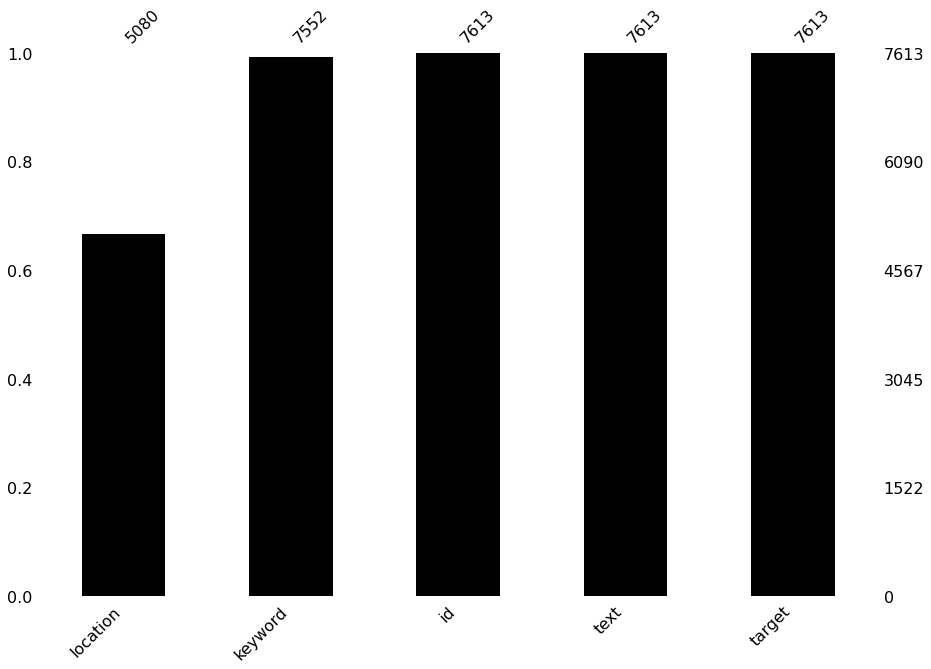

In [5]:
msno.bar(df, color = (0, 0, 0), sort = "ascending", figsize = (15, 10))
plt.show()

Lets see how our class distribution look like

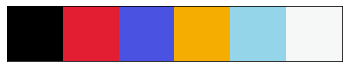

In [6]:
custom_colors = ['#000000', '#E31E33', '#4A53E1', '#F5AD02', '#94D5EA', '#F6F8F7']
custom_palette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors), size = 1)
plt.tick_params(axis = 'both', labelsize = 0, length = 0)

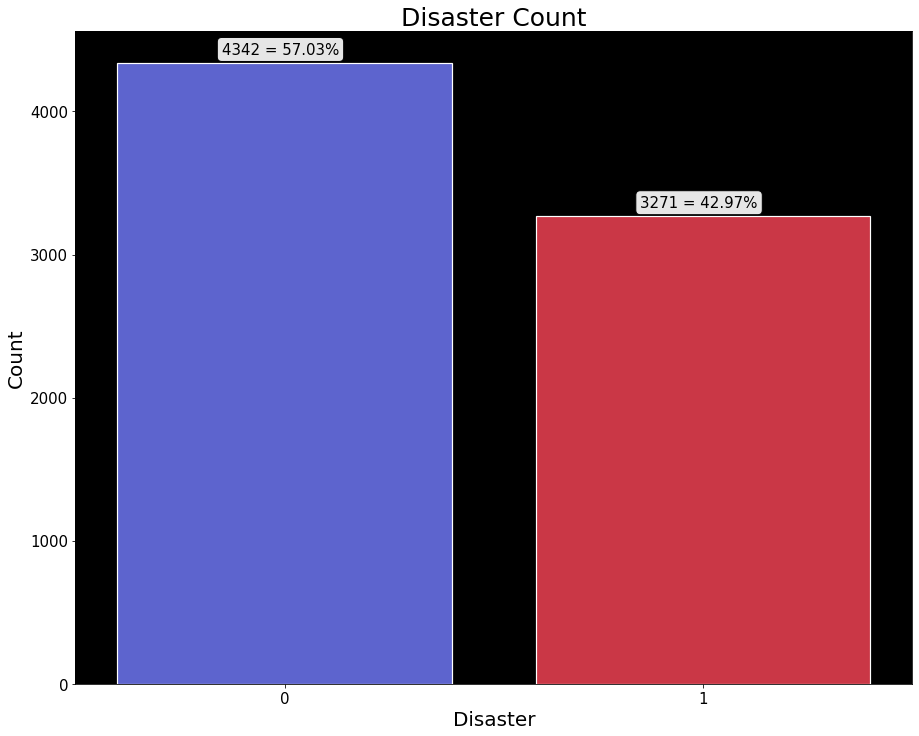

In [7]:
plt.figure(figsize = (15, 12))
ax = plt.axes()
ax.set_facecolor('black')
ax = sns.countplot(x = 'target', data = df, palette = [custom_colors[2], custom_colors[1]], edgecolor = 'white', linewidth = 1.2)
plt.title('Disaster Count', fontsize = 25)
plt.xlabel('Disaster', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
ax.xaxis.set_tick_params(labelsize = 15)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f} = {:.2f}%'.format(p.get_height(), (p.get_height() / len(df['target'])) * 100), (p.get_x() + 0.25, p.get_height() + 60), 
                   color = 'black',
                   bbox = bbox_args,
                   fontsize = 15)
plt.show()

In [8]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
#label 0 = non diaster
#label 1 = disaster

**We have data imbalance so im undersampling the majority class**

In [10]:
new_df0=df[df['target']==0]
new_df1=df[df['target']==1]

In [11]:
new_df1.shape[0]

3271

In [12]:
new_df0=new_df0.sample(new_df1.shape[0]) #generating random samples from majority class same as of the minority class

In [13]:
df=pd.concat([new_df0,new_df1],axis=0)   #appending both the classes with equal number of observations

In [14]:
from sklearn.utils import shuffle   #shuffling the values
df = shuffle(df)

In [15]:
df=df.reset_index(drop=True)

In [16]:
df

,id,keyword,location,text,target
0,3319,demolished,NaN,Why is CHURCH media and #Media420 silent when ...,1
1,2537,collision,"Peterborough, Ontario, Canada",Two-vehicle collision at Fowlers Corners at Hw...,1
2,344,annihilated,London,A fun filled happy-hour at Simmons bar in Camd...,0
3,9180,suicide%20bomber,NaN,IS claims suicide bombing against Saudi police...,1
4,7895,radiation%20emergency,"LP, MN USA",http://t.co/X5XUMtoEkE Nuclear Emergency Curre...,0
...,...,...,...,...,...
6537,6427,hurricane,NaN,#kick #hurricane Seriously #simple websites: h...,1
6538,8213,riot,NaN,Riot Kit Bah - part of the new concept Gear co...,0
6539,799,battle,UK Great Britain,I added a video to a @YouTube playlist http://...,0
6540,4272,drowning,"Hughes, AR",http://t.co/9y0pAJ8sxd Family mourns drowning ...,1


Top 10 locations of tweets

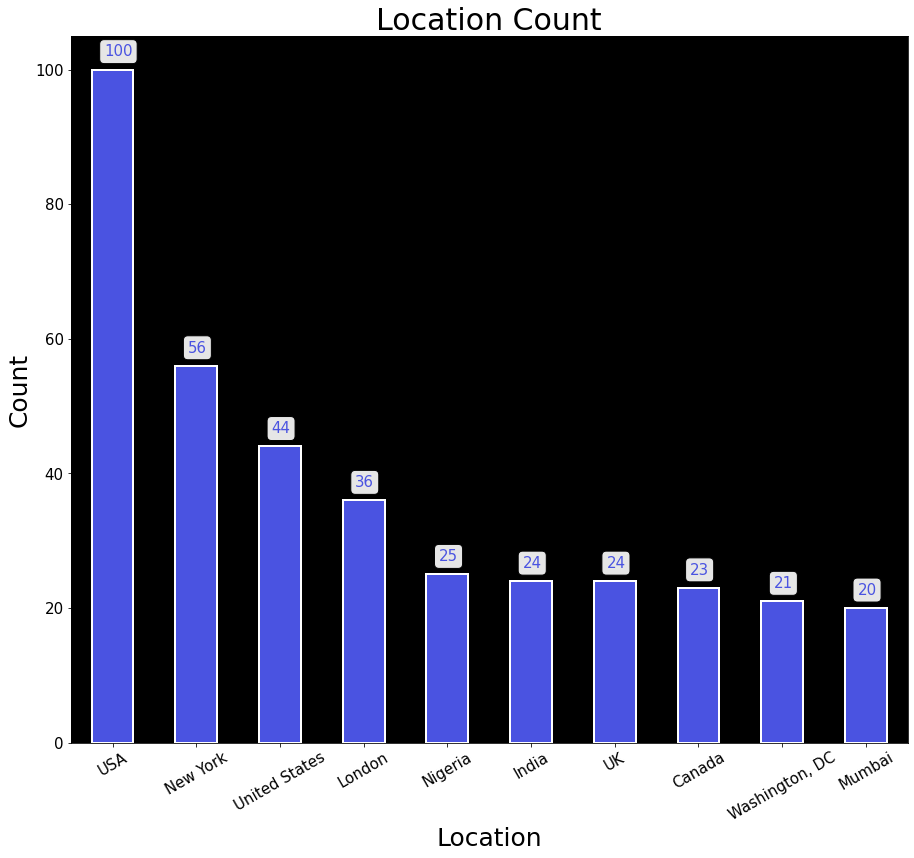

In [17]:
plt.figure(figsize = (15, 13))
ax = plt.axes()
ax.set_facecolor('black')
ax = ((df.location.value_counts())[:10]).plot(kind = 'bar', color = custom_colors[2], linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 30)
plt.xlabel('Location', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
ax.xaxis.set_tick_params(labelsize = 15, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height() + 2),
                   bbox = bbox_args,
                   color = custom_colors[2],
                   fontsize = 15)

**Data Preprocessing**

In [18]:
# %20 is the URL encoding of space, let's replace them with '_'
def re_encode_space(input_string):
    return None if pd.isna(input_string) else input_string.replace('%20', '_')


# Let's try to find hastags
import re

def find_hash_tags(input_string):
    hash_tags = re.findall(r"#(\w+)", str(input_string))
    return ','.join(hash_tags)


# Let's turn hashtags to normal words
def re_encode_hashtags(input_string):
    return None if pd.isna(input_string) else input_string.replace('#', '')


# Let's remove URLs from the tweets
def remove_links(input_string):
    res = input_string
    urls = re.findall(r'(https?://[^\s]+)', res)
    for link in urls:
        res = res.strip(link)
    return res


# Let's remove the state abbreviations
def state_renaming(input_string):

    states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District_of_Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NC': 'North_Carolina',
        'ND': 'North_Dakota',
        'NE': 'Nebraska',
        'NH': 'New_Hampshire',
        'NJ': 'New_Jersey',
        'NM': 'New_Mexico',
        'NV': 'Nevada',
        'NY': 'New_York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'RI': 'Rhode_Island',
        'SC': 'South_Carolina',
        'SD': 'South_Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West_Virginia',
        'WY': 'Wyoming'
    }

    result = input_string
    
    if isinstance(input_string, str):
        input_candidates = input_string.split(', ')
        
        if len(input_candidates) > 1:
            for candidate in input_candidates:
                if candidate in states.keys():
                    result = states[candidate]
                
    if input_string in states.keys():
        result = states[input_string]

    return result

In [19]:
# Let's wrap the preprocessing functions so it's easier to
# process both train and test dataset
def preprocess_data(input_data):
    input_df = input_data.copy()
    input_df['keyword'] = input_df['keyword'].map(re_encode_space)
    input_df['keyword'].fillna('Missing', inplace=True)
    input_df['hashtags'] = input_df['text'].map(find_hash_tags)
    input_df['text'] = input_df['text'].map(re_encode_hashtags)
    input_df['text'] = input_df['text'].map(remove_links)
    input_df['location'] = input_df['location'].map(state_renaming)
    return input_df

In [20]:
# our training data is df

importing test data

In [21]:
test_data=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [22]:
#we are going to rename train data as original_data and test as test_data

In [23]:
original_data = preprocess_data(df)
test_data = preprocess_data(test_data)

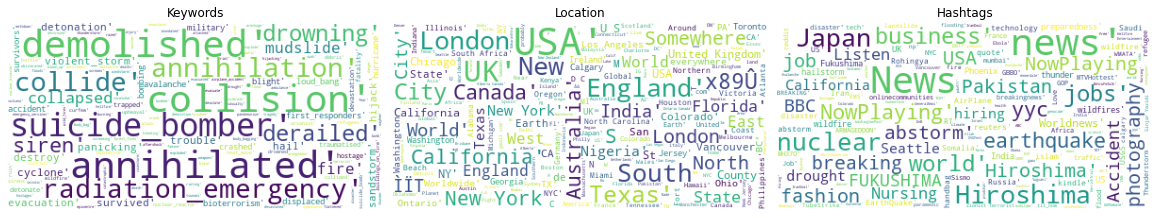

In [24]:
# We notice that keyword field has missing values
# We notice location has missing values

# Let's Visualize the keyword field in a word cloud to get an idea of what it is
import matplotlib.pyplot as plt
from wordcloud import WordCloud

keyword_words = str(original_data['keyword']
    .dropna()
    .unique()
    .tolist()
)

location_words = str(original_data['location']
    .dropna()
    .unique()
    .tolist()
)

hashtag_words = str(original_data['hashtags']
    .dropna()
    .unique()
    .tolist()
)

keyword_wordcloud = WordCloud(
    background_color='white',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(keyword_words)

location_wordcloud = WordCloud(
    background_color='white',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(location_words)

hashtag_wordcloud = WordCloud(
    background_color='white',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(hashtag_words)

fig, ax = plt.subplots(1,3, figsize=(16,9), constrained_layout=True)
ax[0].set_title("Keywords")
ax[0].imshow(keyword_wordcloud)
ax[0].axis(False)
ax[1].set_title('Location')
ax[1].imshow(location_wordcloud)
ax[1].axis(False)
ax[2].set_title('Hashtags')
ax[2].imshow(hashtag_wordcloud)
ax[2].axis(False)
plt.show()

TF-IDF + LogistiRegression

In [25]:
X = original_data['text']
y = original_data['target']

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [27]:
skf = StratifiedKFold(n_splits=5)
train_average_score = 0
validation_average_score = 0
validation_oof_predictions = np.zeros((len(X)))

for fold_n, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    model = Pipeline([
        ('Encoder', TfidfVectorizer(max_features=None)),
        ('Clf', LogisticRegression(penalty='l2', C=1, solver='liblinear'))
    ])
    
    model.fit(X_train, y_train)
    
    train_predictions = model.predict_proba(X_train)[:, 1]
    validation_predictions = model.predict_proba(X_test)[:, 1]
    
    train_score = roc_auc_score(y_train, train_predictions)
    validation_score = roc_auc_score(y_test, validation_predictions)
    
    train_average_score += train_score / 5
    validation_average_score += validation_score / 5
    validation_oof_predictions[test_idx,] = (validation_predictions > 0.5).astype(int)
    
    print(f'Fold: {fold_n}, train auc: {train_score:.3f}, validation auc: {validation_score:.3f}')
print(f'Train average: {train_average_score:.3f}, validation average: {validation_average_score:.3f}')
print(f'OOF Accuracy Score: {accuracy_score(y, validation_oof_predictions)}')

Fold: 0, train auc: 0.957, validation auc: 0.857
Fold: 1, train auc: 0.959, validation auc: 0.857
Fold: 2, train auc: 0.958, validation auc: 0.862
Fold: 3, train auc: 0.960, validation auc: 0.857
Fold: 4, train auc: 0.959, validation auc: 0.849
Train average: 0.959, validation average: 0.856
OOF Accuracy Score: 0.7858453072454906


In [28]:
#Tokeninzing

In [29]:
from nltk.tokenize import TweetTokenizer
# The tokenizer is responsible to turn a string of words
# into a list of tokens (words) for which we'll get their
# vector representation (embeddings)
tknzr = TweetTokenizer(
    preserve_case=False,
    reduce_len=True,
    strip_handles=True,
)


def tokenize_tweets(tokenizer, input_text):
    tokens = list(tokenizer.tokenize(input_text))
    tokens = [re.sub('[^A-Za-z0-9]+', '', i) for i in tokens]
    return tokens

original_data['tokens'] = original_data['text']
original_data['tokens'] = original_data['tokens'].apply(lambda x: tokenize_tweets(tknzr, x))

test_data['tokens'] = test_data['text'].apply(lambda x: tokenize_tweets(tknzr, x))

In [30]:
# We'll pad all embeddings to match the length of the biggest tweet
# in order to account for the variability in tweet length
# Later on the model is going to mask the padded values, so that
# they won't influence the result
max_tweet_length = max(original_data['tokens'].apply(lambda x: len(x)).max(), 
                       test_data['tokens'].apply(lambda x: len(x)).max())

USING BERT Embeddings

In [31]:
X = original_data['text'].tolist()
y = np.asarray(original_data['target'].tolist()).astype(np.float32)

test_array = test_data['text'].tolist()

In [32]:
from transformers import AutoTokenizer, AutoConfig,TFBertModel

In [33]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

X = bert_tokenizer(
    text=X,
    add_special_tokens=True,
    max_length=max_tweet_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

test_array = bert_tokenizer(
    text=test_array,
    add_special_tokens=True,
    max_length=max_tweet_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-05-08 03:57:15.319855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 03:57:15.321014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 03:57:15.321725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 03:57:15.322674: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-05-08 03:57:23.422978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


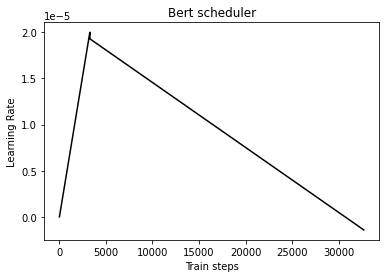

In [34]:
epochs = 5
steps_per_epoch = X['input_ids'].numpy().shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

class BertLrSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    @tf.function
    def __init__(self, initial_learning_rate, num_warmups, num_train_steps):
        self.overshoot = 1000
        self.initial_learning_rate = initial_learning_rate
        self.num_warmups = num_warmups
        self.num_train_steps = num_train_steps
        self.angle_warm = self.initial_learning_rate / self.num_warmups
        self.angle_decay = - self.initial_learning_rate / \
            (self.num_train_steps - self.num_warmups - self.overshoot)
    
    @tf.function
    def __call__(self, step):
        if step <= self.num_warmups:
            return (tf.cast(step, tf.float32) + 1) * self.angle_warm
        else:
            return self.initial_learning_rate + (tf.cast(step, tf.float32) - self.num_warmups + 1 + self.overshoot) * self.angle_decay
        
        
schedule = BertLrSchedule(initial_learning_rate=2e-5, 
                          num_warmups=num_warmup_steps, 
                          num_train_steps=num_train_steps)

steps = np.arange(num_train_steps)
lrs = [schedule.__call__(i) for i in steps]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.plot(steps, lrs)
ax.set_xlabel('Train steps')
ax.set_ylabel('Learning Rate')
ax.set_title('Bert scheduler')
plt.show()

**Model Building**

In [35]:
from tensorflow.keras.optimizers import Adam

In [36]:
def build_bert_classifier():
    input_ids = tf.keras.layers.Input(shape=(max_tweet_length,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(max_tweet_length,), dtype=tf.int32, name="attention_mask")
    embeddings = bert(input_ids,attention_mask = input_mask)['pooler_output']
    net = tf.keras.layers.Dropout(0.1)(embeddings)
    net = tf.keras.layers.Dense(128, activation='relu', name='pre-clf')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(inputs=[input_ids, input_mask], outputs=net)

skf = StratifiedKFold(n_splits=5)
train_average_score = 0
validation_average_score = 0
validation_oof_predictions = np.zeros((len(X['input_ids'].numpy())))

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=schedule)
epochs = 5

# It's a good practice to predict the test set on every fold
# And average the predictions over the folds
averaged_test_predictions = np.zeros((test_array['input_ids'].shape[0]))

# It's standard practice to use Stratified k-fold cross validation
# so we're also using it here
for fold_n, (train_idx, test_idx) in enumerate(skf.split(X['input_ids'].numpy(), y)):
    X_train_ids = X['input_ids'].numpy()[train_idx]
    X_train_att = X['attention_mask'].numpy()[train_idx]
    y_train = y[train_idx]
    
    X_test_ids = X['input_ids'].numpy()[test_idx]
    X_test_att = X['attention_mask'].numpy()[test_idx]
    y_test = y[test_idx]
    
    # Re-build the model at every fold to "reset" it
    model = build_bert_classifier()
    model.layers[2].trainable = True
    
    model.compile(optimizer=optimizer,
                  loss=loss)
    
    model.fit(x={'input_ids':X_train_ids,'attention_mask':X_train_att}, 
              y=y_train, batch_size=32, epochs=epochs)
    
    train_predictions = model.predict({'input_ids':X_train_ids,'attention_mask':X_train_att})
    validation_predictions = model.predict({'input_ids':X_test_ids,'attention_mask':X_test_att})
    
    train_score = roc_auc_score(y_train, train_predictions)
    validation_score = roc_auc_score(y_test, validation_predictions)
    
    train_average_score += train_score / 5
    validation_average_score += validation_score / 5
    validation_oof_predictions[test_idx,] = (validation_predictions > 0.5).astype(int).flatten()
    
    print(f'Fold: {fold_n}, train auc: {train_score:.3f}, validation auc: {validation_score:.3f}')
    
    test_predictions = model.predict({'input_ids':test_array['input_ids'],
                                      'attention_mask':test_array['attention_mask']}).flatten()
    averaged_test_predictions += test_predictions / 5
    
print(f'Train average: {train_average_score:.3f}, validation average: {validation_average_score:.3f}')
print(f'OOF Accuracy Score: {accuracy_score(y, validation_oof_predictions)}')

Epoch 1/5
164/164 [==============================] - 48s 207ms/step - loss: 0.7396
Epoch 2/5
164/164 [==============================] - 34s 207ms/step - loss: 0.6072
Epoch 3/5
164/164 [==============================] - 34s 207ms/step - loss: 0.4960
Epoch 4/5
164/164 [==============================] - 34s 207ms/step - loss: 0.4229
Epoch 5/5
164/164 [==============================] - 34s 207ms/step - loss: 0.3883
Fold: 0, train auc: 0.929, validation auc: 0.898
Epoch 1/5
164/164 [==============================] - 49s 207ms/step - loss: 0.4044
Epoch 2/5
164/164 [==============================] - 34s 207ms/step - loss: 0.3420
Epoch 3/5
164/164 [==============================] - 34s 207ms/step - loss: 0.2967
Epoch 4/5
164/164 [==============================] - 34s 208ms/step - loss: 0.2514
Epoch 5/5
164/164 [==============================] - 34s 208ms/step - loss: 0.2019
Fold: 1, train auc: 0.990, validation auc: 0.923
Epoch 1/5
164/164 [==============================] - 49s 207ms/step - lo

**Creating the submission file from predictions**

In [37]:
sub=pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sub['target']=(averaged_test_predictions > 0.5).astype(int)
sub.to_csv("submission.csv",index=False)

In [38]:
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
